In [5]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Bidirectional, LSTM, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense

In [9]:
# run the model training on GPU if available
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [12]:
# BMKG Dataset
import pandas as pd
BMKG_features = pd.read_csv("../BMKG_features.csv")
print("BMKG Dataset:")
print(BMKG_features.head())

BMKG Dataset:
   Latitude  Longitude     Depth  Magnitude                 Datetime  Year  \
0     -9.18     119.06  0.010695   0.565217  2008-11-01 21:02:43.058  2008   
1     -6.55     129.64  0.010695   0.521739  2008-11-01 20:58:50.248  2008   
2     -7.01     106.63  0.159091   0.391304  2008-11-01 17:43:12.941  2008   
3     -3.30     127.85  0.010695   0.318841  2008-11-01 16:24:14.755  2008   
4     -6.41     129.54  0.090909   0.478261  2008-11-01 16:20:37.327  2008   

   Month  Day  DayOfWeek  Hour MagnitudeCategory  TimeDiff  
0     11    1          5    21               Low  0.000000  
1     11    1          5    20               Low -0.064669  
2     11    1          5    17               Low -3.260363  
3     11    1          5    16               Low -1.316163  
4     11    1          5    16               Low -0.060397  


In [13]:
# Remove 'Datetime' and 'MagnitudeCategory' from features and target
X_bmkg = BMKG_features[["Latitude", "Longitude", "Depth", "TimeDiff", "Year", "Month", "Day", "DayOfWeek", "Hour"]].values

# Use 'Magnitude' as the target variable for regression
y_bmkg = BMKG_features[["Magnitude"]].values

# Check shapes after selection
print("X_bmkg shape:", X_bmkg.shape)
print("y_bmkg shape:", y_bmkg.shape)

X_bmkg shape: (92887, 9)
y_bmkg shape: (92887, 1)


In [14]:
# check if the data is already scaled
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_bmkg_scaled = scaler.fit_transform(X_bmkg)
y_bmkg_scaled = scaler.fit_transform(y_bmkg)

# Check the scaled values
print("Scaled X_bmkg:")
print(X_bmkg_scaled[:5])
print("Scaled y_bmkg:")
print(y_bmkg_scaled[:5])


Scaled X_bmkg:
[[0.10705882 0.52188412 0.01069519 0.33210184 0.         0.90909091
  0.         0.83333333 0.91304348]
 [0.26176471 0.74239266 0.01069519 0.3320872  0.         0.90909091
  0.         0.83333333 0.86956522]
 [0.23470588 0.26281784 0.15909091 0.3313637  0.         0.90909091
  0.         0.83333333 0.73913043]
 [0.45294118 0.70508545 0.01069519 0.33180386 0.         0.90909091
  0.         0.83333333 0.69565217]
 [0.27       0.74030846 0.09090909 0.33208816 0.         0.90909091
  0.         0.83333333 0.69565217]]
Scaled y_bmkg:
[[0.56521739]
 [0.52173913]
 [0.39130435]
 [0.31884058]
 [0.47826087]]


In [15]:
# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split

X_train_bmkg, X_test_bmkg, y_train_bmkg, y_test_bmkg = train_test_split(
    X_bmkg_scaled, y_bmkg, test_size=0.2, random_state=42
)

print("X_train_bmkg shape:", X_train_bmkg.shape)
print("X_test_bmkg shape:", X_test_bmkg.shape)
print("y_train_bmkg shape:", y_train_bmkg.shape)
print("y_test_bmkg shape:", y_test_bmkg.shape)

X_train_bmkg shape: (74309, 9)
X_test_bmkg shape: (18578, 9)
y_train_bmkg shape: (74309, 1)
y_test_bmkg shape: (18578, 1)


In [26]:
# Reshape for LSTM/BiLSTM
# Ensure input data has the correct shape for the model
X_train_bmkg = X_train_bmkg.reshape(X_train_bmkg.shape[0], X_train_bmkg.shape[2])
X_test_bmkg = X_test_bmkg.reshape(X_test_bmkg.shape[0], X_test_bmkg.shape[2])

print("X_train_bmkg reshaped:", X_train_bmkg.shape)
print("X_test_bmkg reshaped:", X_test_bmkg.shape)

X_train_bmkg reshaped: (74309, 9)
X_test_bmkg reshaped: (18578, 9)


In [27]:
# save the data in numpy format
np.save('../X_train_bmkg.npy', X_train_bmkg)
np.save('../X_test_bmkg.npy', X_test_bmkg)
np.save('../y_train_bmkg.npy', y_train_bmkg)
np.save('../y_test_bmkg.npy', y_test_bmkg)

In [28]:
print("X_train_bmkg shape:", X_train_bmkg.shape)
print("X_test_bmkg shape:", X_test_bmkg.shape)
print("y_train_bmkg shape:", y_train_bmkg.shape)
print("y_test_bmkg shape:", y_test_bmkg.shape)

X_train_bmkg shape: (74309, 9)
X_test_bmkg shape: (18578, 9)
y_train_bmkg shape: (74309, 1)
y_test_bmkg shape: (18578, 1)


In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten, Multiply, Softmax, Reshape
)
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
# Use the cyclical learning rate scheduler
def cyclical_lr(initial_learning_rate, maximal_learning_rate, step_size):
    """
    Cyclical learning rate scheduler.
    """
    # Define the learning rate scheduler
    clr = ReduceLROnPlateau(
        min_lr=initial_learning_rate,
        max_lr=maximal_learning_rate,
        step_size=step_size
    )
    return clr

# Learning rate scheduler
reduce_lr = cyclical_lr(  # Use the cyclical learning rate scheduler
    initial_learning_rate=0.001,
    maximal_learning_rate=0.1,
    step_size=2000
)


# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, verbose=1, restore_best_weights=True
)

# Define a custom attention mechanism
def attention_mechanism(inputs):
    """
    Custom attention layer for a given input sequence.
    """
    attention = Dense(1, activation='tanh')(inputs)  # Compute the attention scores
    attention = Softmax()(attention)  # Apply softmax to normalize the scores
    attention = Multiply()([inputs, attention])  # Apply weights to the inputs
    return attention

# Define the CNN-BiLSTM-BMKG model
def build_cnn_bilstm_model(input_shape):
    """
    Builds the CNN-BiLSTM-BMKG model with the attention mechanism.
    """
    inputs = Input(shape=input_shape)
    
    # Reshape inputs to add a "time step" dimension (required for Conv1D and LSTM layers)
    reshaped_inputs = Reshape((input_shape[0], 1))(inputs)
    
    # CNN Block
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(reshaped_inputs)
    x = MaxPooling1D(pool_size=2, strides=1, padding='same')(x)
    
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, strides=1, padding='same')(x)
    
    x = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, strides=1, padding='same')(x)
    
    
    # BiLSTM Block
    x = Bidirectional(LSTM(units=256, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(units=128, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    
    # Attention Mechanism
    x = attention_mechanism(x)
    
    # Fully Connected Block
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)  # Output layer for regression
    
    # Compile the Model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [8]:
# Function to train the model and evaluate
def train_and_evaluate_model(X_train, y_train, X_test, y_test, dataset_name):
    """
    Train and evaluate the CNN-BiLSTM-BMKG model on a specific dataset.
    """
    input_shape = (X_train.shape[1],)  # number of features
    model = build_cnn_bilstm_model(input_shape)

    # Print model summary
    print(f"Training model for {dataset_name}...")
    model.summary()
    
    # Add callbacks
    callbacks = [reduce_lr, early_stopping]
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=64,
        callbacks=[reduce_lr, early_stopping],
        verbose=1
    )

    # Evaluate the model
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f"{dataset_name} Test Loss (MSE): {test_loss}")
    print(f"{dataset_name} Test MAE: {test_mae}")

    # Save the model
    model.save(f'cnn_bilstm_model_{dataset_name.lower()}.h5')

    return history, test_loss, test_mae

# BMKG Dataset
print("Loading BMKG Dataset...")
X_train_bmkg = np.load('../X_train_bmkg.npy', allow_pickle=True)
X_test_bmkg = np.load('../X_test_bmkg.npy', allow_pickle=True)
y_train_bmkg = np.load('../y_train_bmkg.npy', allow_pickle=True)
y_test_bmkg = np.load('../y_test_bmkg.npy', allow_pickle=True)

history_bmkg, test_loss_bmkg, test_mae_bmkg = train_and_evaluate_model(X_train_bmkg, y_train_bmkg, X_test_bmkg, y_test_bmkg, "BMKG")

Loading BMKG Dataset...
Training model for BMKG...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 9, 1)         0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 9, 64)        256         reshape_1[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_3 (MaxPooling1D)  (None, 9, 64)        0           conv1d_3[0][0]                   
_________________________________________

In [4]:
# show the model accuracy Percentage for BMKG Dataset out of 100%
print("BMKG Test Loss (MSE):", test_loss_bmkg)
print("BMKG Test MAE:", test_mae_bmkg)

BMKG Test Loss (MSE): 0.014789507176018414
BMKG Test MAE: 0.09840562


In [ ]:
BMKG Test Loss (MSE): 0.008427958246156058
BMKG Test MAE: 0.07138015


BMKG Test Loss (MSE): 0.014789507176018414
BMKG Test MAE: 0.09840562

In [ ]:
# evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the model
model_bmkg = load_model('cnn_bilstm_model_bmkg.h5')

# Make predictions
y_pred_bmkg = model_bmkg.predict(X_test_bmkg)

# Calculate the Mean Squared Error
mse_bmkg = mean_squared_error(y_test_bmkg, y_pred_bmkg)
print("BMKG Test MSE:", mse_bmkg)

# Calculate the Mean Absolute Error
mae_bmkg = mean_absolute_error(y_test_bmkg, y_pred_bmkg)
print("BMKG Test MAE:", mae_bmkg)

# Calculate the Root Mean Squared Error
rmse_bmkg = np.sqrt(mse_bmkg)
print("BMKG Test RMSE:", rmse_bmkg)

# Calculate the Mean Absolute Percentage Error
mape_bmkg = np.mean(np.abs((y_test_bmkg - y_pred_bmkg) / y_test_bmkg)) * 100
print("BMKG Test MAPE:", mape_bmkg)

# Calculate the Coefficient of Determination (R^2)
from sklearn.metrics import r2_score
r2_bmkg = r2_score(y_test_bmkg, y_pred_bmkg)
print("BMKG Test R^2:", r2_bmkg)


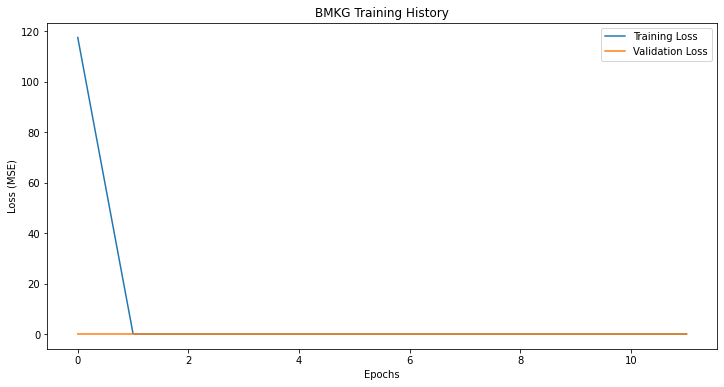

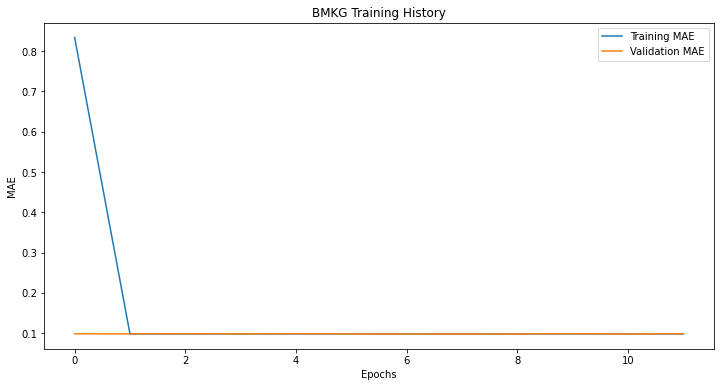

In [5]:
# Plot the training history
import matplotlib.pyplot as plt

def plot_training_history(history, dataset_name):
    """
    Plot the training history for a given dataset.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{dataset_name} Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'{dataset_name} Training History')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()
    
# Plot the training history for BMKG
plot_training_history(history_bmkg, "BMKG")

In [20]:
# JMA Dataset
import pandas as pd
JMA_features = pd.read_csv("../JMA_features.csv")
print("JMA Dataset:")
print(JMA_features.head())

JMA Dataset:
    Latitude   Longitude  Depth  Magnitude             Datetime  Year  Month  \
0  35.338333  133.211667     12        3.6  1985-12-31 02:26:48  1985     12   
1  36.406667  140.696667     55        3.3  1985-12-30 19:11:46  1985     12   
2  37.210000  139.936667      6        3.5  1985-12-30 15:56:17  1985     12   
3  27.968333  129.665000      0        4.2  1985-12-30 15:20:15  1985     12   
4  42.888333  145.445000     35        3.7  1985-12-29 09:22:20  1985     12   

   Day  DayOfWeek  Hour MagnitudeCategory   TimeDiff  
0   31          1     2          Moderate   0.000000  
1   30          0    19          Moderate  -7.250556  
2   30          0    15          Moderate  -3.258056  
3   30          0    15          Moderate  -0.600556  
4   29          6     9          Moderate -29.965278  


In [21]:
# Remove 'Datetime' and 'MagnitudeCategory' from features and target
X_jma = JMA_features[["Latitude", "Longitude", "Depth", "TimeDiff", "Year", "Month", "Day", "DayOfWeek", "Hour"]].values

# Use 'Magnitude' as the target variable for regression
y_jma = JMA_features[["Magnitude"]].values

# Check shapes after selection
print("X_jma shape:", X_jma.shape)
print("y_jma shape:", y_jma.shape)

X_jma shape: (93203, 9)
y_jma shape: (93203, 1)


In [22]:
# check if the data is already scaled
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_jma_scaled = scaler.fit_transform(X_jma)
y_jma_scaled = scaler.fit_transform(y_jma)

# Check the scaled values
print("Scaled X_jma:")
print(X_jma_scaled[:5])
print("Scaled y_jma:")
print(y_jma_scaled[:5])

Scaled X_jma:
[[0.59948847 0.33121805 0.01726619 0.25212269 0.         1.
  1.         0.16666667 0.08695652]
 [0.62024087 0.52912921 0.07913669 0.2518133  0.         1.
  0.96666667 0.         0.82608696]
 [0.63584564 0.50903402 0.00863309 0.25198366 0.         1.
  0.96666667 0.         0.65217391]
 [0.45632608 0.23744051 0.         0.25209706 0.         1.
  0.96666667 0.         0.65217391]
 [0.74614737 0.65468006 0.05035971 0.25084401 0.         1.
  0.93333333 1.         0.39130435]]
Scaled y_jma:
[[0.38636364]
 [0.35227273]
 [0.375     ]
 [0.45454545]
 [0.39772727]]


In [19]:
# Reshape for LSTM/BiLSTM
# Ensure input data has the correct shape for the model
X_train_jma = X_train_jma.reshape(X_train_jma.shape[0], X_train_jma.shape[2])
X_test_jma = X_test_jma.reshape(X_test_jma.shape[0], X_test_jma.shape[2])

print("X_train_jma reshaped:", X_train_jma.shape)
print("X_test_jma reshaped:", X_test_jma.shape)

NameError: name 'X_train_jma' is not defined

In [23]:
# save the data in numpy format
np.save('../X_train_jma.npy', X_train_jma)
np.save('../X_test_jma.npy', X_test_jma)
np.save('../y_train_jma.npy', y_train_jma)
np.save('../y_test_jma.npy', y_test_jma)

NameError: name 'X_train_jma' is not defined

In [24]:
print("X_train_jma shape:", X_train_jma.shape)
print("X_test_jma shape:", X_test_jma.shape)
print("y_train_jma shape:", y_train_jma.shape)
print("y_test_jma shape:", y_test_jma.shape)

NameError: name 'X_train_jma' is not defined

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Flatten, Multiply, Softmax, Reshape
)
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
# Use the cyclical learning rate scheduler
def cyclical_lr(initial_learning_rate, maximal_learning_rate, step_size):
    """
    Cyclical learning rate scheduler.
    """
    # Define the learning rate scheduler
    clr = ReduceLROnPlateau(
        min_lr=initial_learning_rate,
        max_lr=maximal_learning_rate,
        step_size=step_size
    )
    return clr

# Learning rate scheduler
reduce_lr = cyclical_lr(  # Use the cyclical learning rate scheduler
    initial_learning_rate=0.001,
    maximal_learning_rate=0.1,
    step_size=2000
)


# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, verbose=1, restore_best_weights=True
)

# Define a custom attention mechanism
def attention_mechanism(inputs):
    """
    Custom attention layer for a given input sequence.
    """
    attention = Dense(1, activation='tanh')(inputs)  # Compute the attention scores
    attention = Softmax()(attention)  # Apply softmax to normalize the scores
    attention = Multiply()([inputs, attention])  # Apply weights to the inputs
    return attention

# Define the CNN-BiLSTM-BMKG model
def build_cnn_bilstm_model(input_shape):
    """
    Builds the CNN-BiLSTM-BMKG model with the attention mechanism.
    """
    inputs = Input(shape=input_shape)
    
    # Reshape inputs to add a "time step" dimension (required for Conv1D and LSTM layers)
    reshaped_inputs = Reshape((input_shape[0], 1))(inputs)
    
    # CNN Block
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(reshaped_inputs)
    x = MaxPooling1D(pool_size=2, strides=1, padding='same')(x)
    
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, strides=1, padding='same')(x)
    
    x = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=2, strides=1, padding='same')(x)
    
    
    # BiLSTM Block
    x = Bidirectional(LSTM(units=256, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(units=128, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    
    # Attention Mechanism
    x = attention_mechanism(x)
    
    # Fully Connected Block
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(1, activation='linear')(x)  # Output layer for regression
    
    # Compile the Model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [26]:
# Function to train the model and evaluate
def train_and_evaluate_model(X_train, y_train, X_test, y_test, dataset_name):
    """
    Train and evaluate the CNN-BiLSTM-BMKG model on a specific dataset.
    """
    input_shape = (X_train.shape[1],)  # number of features
    model = build_cnn_bilstm_model(input_shape)

    # Print model summary
    print(f"Training model for {dataset_name}...")
    model.summary()
    
    # Add callbacks
    callbacks = [reduce_lr, early_stopping]
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=64,
        callbacks=[reduce_lr, early_stopping],
        verbose=1
    )

    # Evaluate the model
    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f"{dataset_name} Test Loss (MSE): {test_loss}")
    print(f"{dataset_name} Test MAE: {test_mae}")

    # Save the model
    model.save(f'cnn_bilstm_model_{dataset_name.lower()}.h5')

    return history, test_loss, test_mae


# JMA Dataset
print("Training for JMA Dataset...")
X_train_jma = np.load('../X_train_jma.npy', allow_pickle=True)
X_test_jma = np.load('../X_test_jma.npy', allow_pickle=True)
y_train_jma = np.load('../y_train_jma.npy', allow_pickle=True)
y_test_jma = np.load('../y_test_jma.npy', allow_pickle=True)

history_jma, test_loss_jma, test_mae_jma = train_and_evaluate_model(X_train_jma, y_train_jma, X_test_jma, y_test_jma, "JMA")

Training for JMA Dataset...
Training model for JMA...
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 4, 1)         0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 4, 64)        256         reshape_2[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_6 (MaxPooling1D)  (None, 4, 64)        0           conv1d_6[0][0]                   
______________________________________

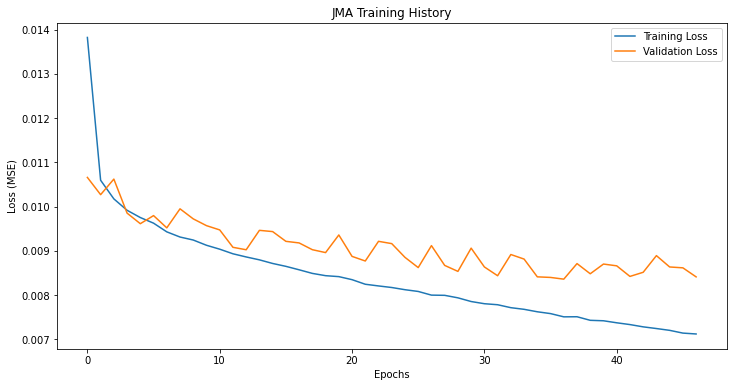

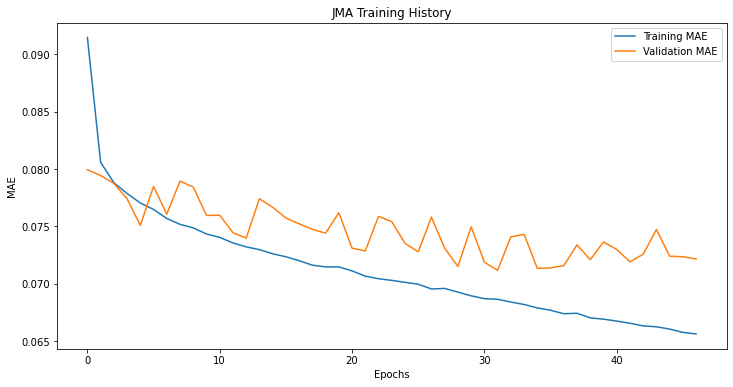

In [27]:
# Plot the training history for JMA
# Plot the training history
import matplotlib.pyplot as plt

def plot_training_history(history, dataset_name):
    """
    Plot the training history for a given dataset.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{dataset_name} Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'{dataset_name} Training History')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()
    
# Plot the training history for BMKG
plot_training_history(history_bmkg, "JMA")